In [1]:
%matplotlib inline

In [2]:
# Reguired libraries
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.basemap import cm as basemap_cm
import seaborn as sns
from collections import OrderedDict
from netCDF4 import num2date
from scipy.stats import ranksums, ttest_ind
from scipy.spatial import ConvexHull
from datetime import datetime
from calendar import month_abbr, month_name
from netCDF4 import date2num, num2date

# For temporary display of existing figures
from IPython.display import Image

# RASM lib plotting utilities
from rasmlib.calendar import dpm
from rasmlib.analysis.climatology import season_mean, annual_mean
from rasmlib.analysis.plotting import cmap_discretize, sub_plot_pcolor, projections, default_map, make_bmap, seasons

In [3]:
ncfiles = {}

ncdata = {}
# Grid and domain files
# need to update paths on these files and make sure they are correctly ported over
ncfiles['rasm_domain'] = '/p/cwfs/gergel/compare_data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.100920.nc'
ncfiles['rasm_masks'] = '/p/cwfs/gergel/compare_data/inputdata/RASM_VICRVIC_GRID_MASKS_AND_METRICS.nc'

# import RASM 1.1 data
# R1009RBRceap01a --> RASM 1.1
ncdata['RASM 1.1'] = xr.open_dataset(
    os.path.join('/p/cwfs/gergel/processed/R1009RBRceap01a/lnd/monthly_mean_timeseries', 
                'R1009RBRceap01a.vic.hmm.197909-201412.nc'))

should be three runs analyzed: 

R1009RBRceap01a --> RASM 1.1

R2100aRBRcaaa01a --> RASM 2.0.a

R2100bRBRcaaa01a --> RASM 2.0.b

Should we also include the run from Joe's 2017 paper, which may not have been RASM 1.1 but instead 1.0? R1001 perhaps? 

In [4]:
# import other RASM runs to be analyzed

# R2100aRBRcaaa01a --> RASM 2.0.a
ncdata['RASM 2.0.a'] = xr.open_dataset(
    os.path.join(
        '/p/cwfs/gergel/processed/R2100aRBRcaaa01a/lnd/monthly_mean_timeseries',
    'R2100aRBRcaaa01a.vic.hmm.197909-201612.nc'))

# R2100bRBRcaaa01a --> RASM 2.0.b
ncdata['RASM 2.0.b'] = xr.open_dataset(
    os.path.join(
        '/p/cwfs/gergel/processed/R2100bRBRcaaa01a/lnd/monthly_mean_timeseries',
    'R2100bRBRcaaa01a.vic.hmm.197909-201612.nc'))

ncdata['rasm_domain'] = xr.open_dataset(ncfiles['rasm_domain'])
ncdata['rasm_masks'] = xr.open_dataset(ncfiles['rasm_masks'])

In [10]:
u = xr.open_dataset(os.path.join('/p/cwfs/gergel/processed/R1009RBRceap01a/lnd/daily_mean_timeseries', 
                                'R1009RBRceap01a.vic.hdm.19790901-20141231.nc'))

In [16]:
u.time[12880:]

<xarray.DataArray 'time' (time: 17)>
array(['2014-12-16T00:00:00.000000000', '2014-12-17T00:00:00.000000000',
       '2014-12-18T00:00:00.000000000', '2014-12-19T00:00:00.000000000',
       '2014-12-20T00:00:00.000000000', '2014-12-21T00:00:00.000000000',
       '2014-12-22T00:00:00.000000000', '2014-12-23T00:00:00.000000000',
       '2014-12-24T00:00:00.000000000', '2014-12-25T00:00:00.000000000',
       '2014-12-26T00:00:00.000000000', '2014-12-27T00:00:00.000000000',
       '2014-12-28T00:00:00.000000000', '2014-12-29T00:00:00.000000000',
       '2014-12-30T00:00:00.000000000', '2014-12-31T00:00:00.000000000',
       '2015-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2014-12-16 2014-12-17 2014-12-18 ...
Attributes:
    dimensions:      1
    long_name:       time
    type_preferred:  int

import ERA-Interim data 

In [5]:
# era_interim_ts1 has radiation and precip 
ncdata['era_interim_ts1'] = xr.open_dataset(os.path.join('/p/cwfs/gergel/compare_data/era-interim',
                                                         'wrf-197909-201212.era_i.nc'))
# era_interim_ts2 has tair
ncdata['era_interim_ts2'] = xr.open_dataset(os.path.join('/p/cwfs/gergel/compare_data/era-interim',
                                                         'met_em-197909-201212.nc'))

# era_interim_ts3 has water vars
ncdata['era_interim_ts3'] = xr.open_dataset(os.path.join('/p/cwfs/gergel/compare_data/era-interim',
                                                         'era_water_vars.1979-2014.nc'))



rename vars in ERA-Interim Datasets

In [6]:
# Rename variables in datasets as necessary
# Rename variables in datasets as necessary
name_dicts = {'era_interim_ts1': {'rsus': 'Swup',
                                  'rsds': 'Swin',
                                  'rlus': 'Lwup',
                                  'rlds': 'Lwin',
                                  'hfss': 'Senht',
                                  'hfls': 'Latht',
                                  'snow_depth': 'Swq',
                                  'precip_tot': 'Precipitation',
                                  'LW_deac_net': 'Lwnet',
                                  'SW_deac_net': 'Swnet',
                                  'west_east': 'x',
                                  'south_north': 'y'},
              'era_interim_ts2': {'T_2m': 'Tair',
                                  'west_east': 'x',
                                  'south_north': 'y'},
              'era_interim_ts3': {'tp': 'Precipitation',
                                  'e': 'Evap',
                                  'ro': 'Runoff'}}
for k, v in ncdata.items():
    if k in name_dicts:
        print(k)
        v.rename(name_dicts[k], inplace=True)

era_interim_ts1
era_interim_ts2
era_interim_ts3


post-process ERA-Interim and RASM variables (e.g. some of them need to be converted and/or calculated, e.g. the Bowen ratio)

In [7]:
# add variables or adjust units of datasets if necessary for RASM data
for r in ['RASM 1.1', 'RASM 2.0.a', 'RASM 2.0.b']: 
    ncdata[r]['calc_albedo'] = 1 - (ncdata[r]['Swnet'] / ncdata[r]['Swin'])
    ncdata[r]['Swup'] = ncdata[r]['Swin'] - ncdata[r]['Swnet']
    ncdata[r]['Lwup'] = ncdata[r]['Lwin'] - ncdata[r]['Lwnet']
    ncdata[r]['runoff_tot'] = ncdata[r]['Runoff'] + ncdata[r]['Baseflow']
    ncdata[r]['Radnet'] = ncdata[r]['Swnet'] + ncdata[r]['Lwnet']
    ncdata[r]['Radin'] = ncdata[r]['Swin'] + ncdata[r]['Lwin']
    ncdata[r]['runoff_ratio'] = ncdata[r]['runoff_tot'] / ncdata[r]['Precipitation']
    ncdata[r]['bowen_ratio'] = ncdata[r]['Senht'] / ncdata[r]['Latht']
    ncdata[r]['evap_frac'] = ncdata[r]['Latht'] / (ncdata[r]['Latht'] + ncdata[r]['Senht'])
    ncdata[r]['P-E'] = ncdata[r]['Precipitation'] - ncdata[r]['Evap']
    
# adjust units of variables for ERA-Interim
ncdata['era_interim_ts1']['calc_albedo'] = ncdata['era_interim_ts1']['Swup'] / ncdata['era_interim_ts1']['Swin']
ncdata['era_interim_ts1']['Swnet'] = ncdata['era_interim_ts1']['Swin'] - ncdata['era_interim_ts1']['Swup']
ncdata['era_interim_ts1']['Lwnet'] = ncdata['era_interim_ts1']['Lwin'] - ncdata['era_interim_ts1']['Lwup']
ncdata['era_interim_ts1']['Radnet'] = ncdata['era_interim_ts1']['Swnet'] + ncdata['era_interim_ts1']['Lwnet']
ncdata['era_interim_ts1']['Radin'] = ncdata['era_interim_ts1']['Swin'] + ncdata['era_interim_ts1']['Lwin']
ncdata['era_interim_ts1']['bowen_ratio'] = ncdata['era_interim_ts1']['Senht'] / ncdata['era_interim_ts1']['Latht']
ncdata['era_interim_ts1']['evap_frac'] = 1 / (1 + ncdata['era_interim_ts1']['bowen_ratio'])
for var in ('Runoff', 'Precipitation'):
    ncdata['era_interim_ts3'][var] *= 1000.
ncdata['era_interim_ts3']['Evap'] *= -1000.
ncdata['era_interim_ts3'] = ncdata['era_interim_ts3'].resample('MS', how='mean', dim='time')
ncdata['era_interim_ts3']['runoff_tot'] = ncdata['era_interim_ts3']['Runoff']
ncdata['era_interim_ts3']['runoff_ratio'] = (ncdata['era_interim_ts3']['runoff_tot'] / 
                                             ncdata['era_interim_ts3']['Precipitation'])
ncdata['era_interim_ts3']['P-E'] = ncdata['era_interim_ts3']['Precipitation'] - ncdata['era_interim_ts3']['Evap']

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 


In [8]:
# Setup rasmlib plotting
wr50a_map = make_bmap(projection=projections['wr50a'],
                      lons=ncdata['rasm_domain']['xc'].values,
                      lats=ncdata['rasm_domain']['yc'].values)
ncdata['rasm_masks'] = xr.open_dataset(ncfiles['rasm_masks'])
spatial_plot_mask = ncdata['rasm_masks']['mask_active_land'].values < 0.9

pop_masks = xr.open_dataset('/p/cwfs/gergel/compare_data/inputdata/RASM_POPCICE_GRID_MASKS_AND_METRICS.nc')
wrf_masks = xr.open_dataset('/p/cwfs/gergel/compare_data/inputdata/RASM_WRFVIC_GRID_MASKS_AND_METRICS.nc')

ar9v4_map = make_bmap(projection=projections['wr50a'],
                      lons=pop_masks['longitude'].values,
                      lats=pop_masks['latitude'].values)

In [9]:
def draw_map(lw=0.3):
    wr50a_map.m.drawmapboundary(fill_color=(0.9, 0.9, 0.9))
    wr50a_map.m.fillcontinents(color='white', zorder=0)
    wr50a_map.m.drawparallels(np.arange(-80., 81., 20.), linewidth=lw)
    wr50a_map.m.drawmeridians(np.arange(-180., 181., 20.), linewidth=lw)
    wr50a_map.m.drawcoastlines(color='k', linewidth=lw)
    
def plot_era_anoms(monthly_means, vmin=-25, vmax=25, smin=0, smax=3, amin=-4.5, amax=4.5,
                     cmap='Spectral_r', smap='YlGnBu', amap='RdBu', cbar_extend='both',
                     sbar_extend='max', abar_extend='both', cbar_label= 'Mean', era_interim=True,
                     varname=None, units='-'):
    with sns.axes_style("white"):

        # Set colorbar norms and ticks
        # assert(type(cmap) == str)
        cn = 10
        cmap = cmap_discretize(cmap, n_colors=cn)
        cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cticks = np.linspace(vmin, vmax, num=cn + 1)
        # assert(type(smap) == str)
        cn = 10
        smap = cmap_discretize(smap, n_colors=cn)
        snorm = mpl.colors.Normalize(vmin=smin, vmax=smax)
        sticks = np.linspace(smin, smax, num=cn + 1)
        # assert(type(amap) == str)
        an = 9
        amap = cmap_discretize(amap, n_colors=an)
        anorm = mpl.colors.Normalize(vmin=amin, vmax=amax)
        aticks = np.round(np.linspace(amin, amax, num=an + 1), 1)

        keys = list(monthly_means.keys())
        
        dss_era = monthly_means[keys[0]].resample('QS-SEP', dim='time').groupby('time.season')
        dsa_era = monthly_means[keys[0]].resample('AS', dim='time')
        
        # nrows = len(monthly_means) + 1
        ncols = 5
        width = 11
        
        nrows = 4
        
        # height = 1.55 * nrows + 0.6
        height = 1.55 * nrows + 0.6
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                                 figsize=(width, height),
                                 sharex=True, sharey=True)
        plt.subplots_adjust(left=0.125, bottom=0.05,
                            right=0.9, top=0.9,
                            wspace=0.05, hspace=0.05)
        
        # ERA-Interim means
        season_means_era = dss_era.mean(dim='time')
        annual_means_era = dsa_era.mean(dim='time')
        
        # seasonal/annual means for ERA-Interim as top row
        # ERA-Interim
        for i, season in enumerate(seasons):
            plt.sca(axes[0, i])
            draw_map()
            sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, season_means_era.sel(season=season).to_masked_array()),
                            map_obj=wr50a_map, cbar=None, vmin=vmin, vmax=vmax, cmap=cmap, ax=axes[0, i])


        plt.sca(axes[0, 4])
        draw_map()
        sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, annual_means_era.to_masked_array()),
                        map_obj=wr50a_map, cbar=None, vmin=vmin, vmax=vmax, cmap=cmap, ax=axes[0, 4])

        # anomalies for RASM baseline run 
        count = 1
        for j, key in enumerate(keys[1:]):
            print(key)
            # calculate seasonal means for this dataset
            dss = monthly_means[key].resample('QS-SEP', dim='time').groupby('time.season')
            
            # calculate annual means for this dataset
            dsa = monthly_means[key].resample('AS', dim='time')
            
            # SEASONAL MEANS
            # calculate difference between seasonal means for ERA-Interim and this dataset
            season_anoms_era = (season_means_era - dss.mean(dim='time'))
            
            # ANNUAL MEANS
            # calculate difference between annual means for ERA-Interim and this dataset 
            annual_anoms_era = (annual_means_era - dsa.mean(dim='time'))

            # plot ERA-Interim row 
            for i, season in enumerate(seasons):
                plt.sca(axes[count, i])
                draw_map()
                sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, season_anoms_era.sel(season=season).to_masked_array()),
                                map_obj=wr50a_map, cbar=None, vmin=amin, vmax=amax, cmap=amap, ax=axes[count, i])

            # plot annual anomalies for ERA-Interim
            plt.sca(axes[count, 4])
            draw_map()
            sub_plot_pcolor(np.ma.masked_where(spatial_plot_mask, annual_anoms_era.to_masked_array()),
                            map_obj=wr50a_map, cbar=None, vmin=amin, vmax=amax, cmap=amap, ax=axes[count, 4])
            
            count += 1


        plt.tight_layout()

        # titles = [ax.set_title(str(title)) for title, ax in zip(list(seasons) + ['Annual'], axes[0])]
        new_seasons = list(seasons) + ['Annual']
        for i, ax in enumerate(axes[0]):
            ax.set_title(new_seasons[i])
        # ylabels = [ax.set_ylabel("{0}\n — {1}".format(keys[0], label)) for label, ax in zip(keys[1:], axes[2:, 0])]
        for label, ax in zip(keys[1:], axes[2:, 0]): 
            # ax.set_ylabel("{0}\n — {1}".format(keys[0], label))
            ax.set_ylabel("%s \n - %s" % (keys[0], label))
        # axes[0, 0].set_ylabel(keys[0])
        # axes[1, 0].set_ylabel("{0} (Std.)".format(keys[0]))
        axes[0, 0].set_ylabel("%s" % keys[0])
        
        axes[1, 0].set_ylabel("%s \n - %s" % (keys[0], keys[1]))
        axes[2, 0].set_ylabel("%s \n - %s" % (keys[0], keys[2]))
        axes[3, 0].set_ylabel("%s \n - %s" % (keys[0], keys[3]))

        # Colorbars
        cbar_height = 0.02
        # cbar_width = .313
        cbar_width = 0.47
        ax1 = fig.add_axes([0.01, -cbar_height, cbar_width, cbar_height])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=cnorm,
                                        orientation='horizontal',
                                        extend=cbar_extend,
                                        ticks=cticks)
        
        ax3 = fig.add_axes([0.5, -cbar_height, cbar_width, cbar_height])
        cb3 = mpl.colorbar.ColorbarBase(ax3, cmap=amap, norm=anorm,
                                        orientation='horizontal',
                                        extend=abar_extend,
                                        ticks=aticks)
        if varname is not None:
            cb1.set_label("{0} ({1}, Mean)".format(varname, units))
            # cb2.set_label("{0} ({1}, Std.)".format(varname, units))
            cb3.set_label("{0} ({1}, Anomaly)".format(varname, units))

    return fig, axes

In [74]:
sns.set_style("white")

# Set some general plotting values
fontsize = 12
dpi = 200 # set to 900 for final publication
mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Myriad Pro') 
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['mathtext.default'] = 'sf'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42

fill_color = (0.9, 0.9, 0.9)

plot_direc = '/u/home/gergel/rasm_postprocessing/plots_runoff_analysis'
if not os.path.exists(plot_direc):
    os.makedirs(plot_direc)

samin, samax = -11, 11

In [75]:
runoff_sums = {}

colors = dict(zip(['RASM 1.1', 'RASM 2.0.a', 'RASM 2.0.b'], 
                  ["#0d0002", "#fa4e06", "#bb37da"]))

var = 'runoff_tot'

runoff_sums['RASM 1.1'] = ncdata['RASM 1.1'][var].where(
                           ncdata['RASM 1.1'][var] < 1000000000000000000).sum(['y', 'x'])

runoff_sums['RASM 2.0.a'] = ncdata['RASM 2.0.a'][var].where(
                           ncdata['RASM 2.0.a'][var] < 1000000000000000000).sum(['y', 'x'])
runoff_sums['RASM 2.0.b'] = ncdata['RASM 2.0.b'][var].where(
                           ncdata['RASM 2.0.b'][var] < 1000000000000000000).sum(['y', 'x'])

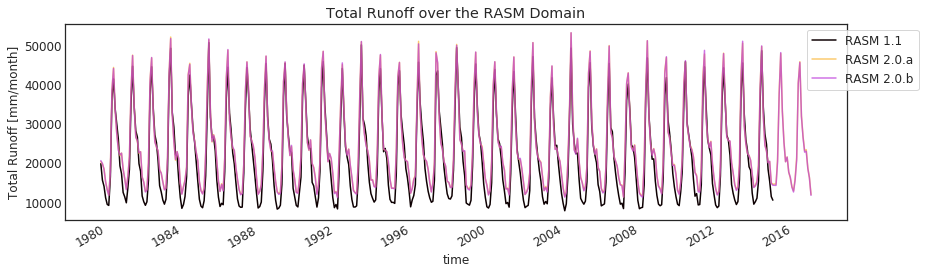

In [76]:
figsize=(14, 4)
fig = plt.figure(figsize=figsize) 

colors = dict(zip(['RASM 1.1', 'RASM 2.0.a', 'RASM 2.0.b'], 
                  ["#0d0002", "#fbb431", "#bb37da"]))

alpha = 0.7

runoff_sums['RASM 1.1'].plot(color=colors['RASM 1.1'], label="RASM 1.1")
runoff_sums['RASM 2.0.a'].plot(color=colors['RASM 2.0.a'], label="RASM 2.0.a", alpha=alpha)
runoff_sums['RASM 2.0.b'].plot(color=colors['RASM 2.0.b'], label="RASM 2.0.b", alpha=alpha)
plt.ylabel('Total Runoff [mm/month]')
plt.title('Total Runoff over the RASM Domain')
plt.legend(bbox_to_anchor=(1.1, 1.0), frameon=True, prop={'size': 12})

plotname = 'total_runoff_timeseries.png'
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatc

RASM 1.1


/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 


RASM 2.0.a
RASM 2.0.b


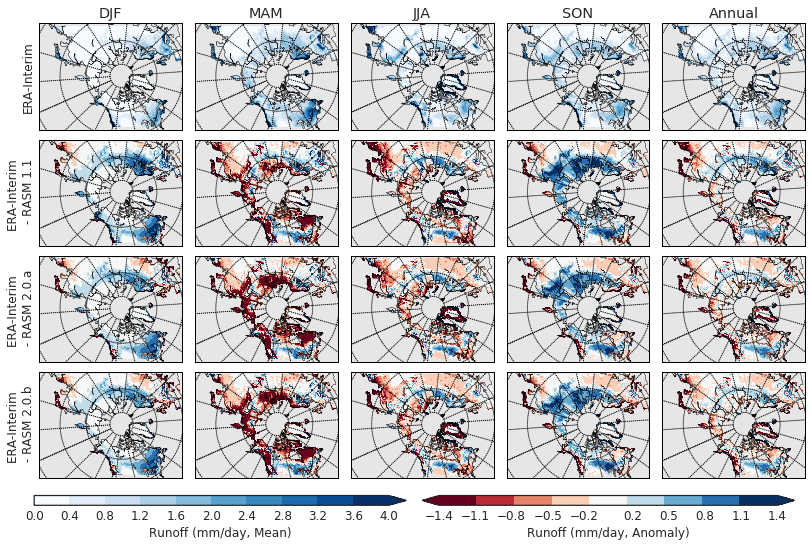

In [77]:
var = 'runoff_tot'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = ncdata['era_interim_ts3'][var]

monthly_means['RASM 1.1'] = ncdata['RASM 1.1'][var]
monthly_means['RASM 2.0.a'] = ncdata['RASM 2.0.a'][var]
monthly_means['RASM 2.0.b'] = ncdata['RASM 2.0.b'][var]

fig, axes = plot_era_anoms(monthly_means, vmin=0., vmax=4, amin = -1.4, 
                             amax = 1.4, varname='Runoff', units='mm/day', cmap='Blues', amap='RdBu',
                             cbar_extend='max', era_interim=True)

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatc

RASM 1.1


/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 


RASM 2.0.a
RASM 2.0.b


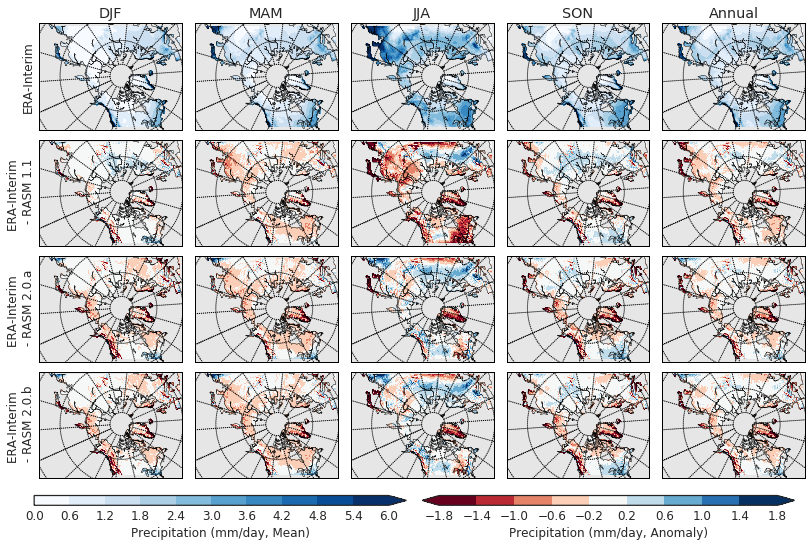

In [78]:
var = 'Precipitation'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = ncdata['era_interim_ts3'][var]

monthly_means['RASM 1.1'] = ncdata['RASM 1.1'][var]
monthly_means['RASM 2.0.a'] = ncdata['RASM 2.0.a'][var]
monthly_means['RASM 2.0.b'] = ncdata['RASM 2.0.b'][var]

fig, axes = plot_era_anoms(monthly_means, vmin=0., vmax=6, smax=2, amin = -1.8, 
                             amax = 1.8, varname='Precipitation', units='mm/day', cmap='Blues', amap='RdBu',
                             cbar_extend='max')

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatc

RASM 1.1


/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 


RASM 2.0.a
RASM 2.0.b


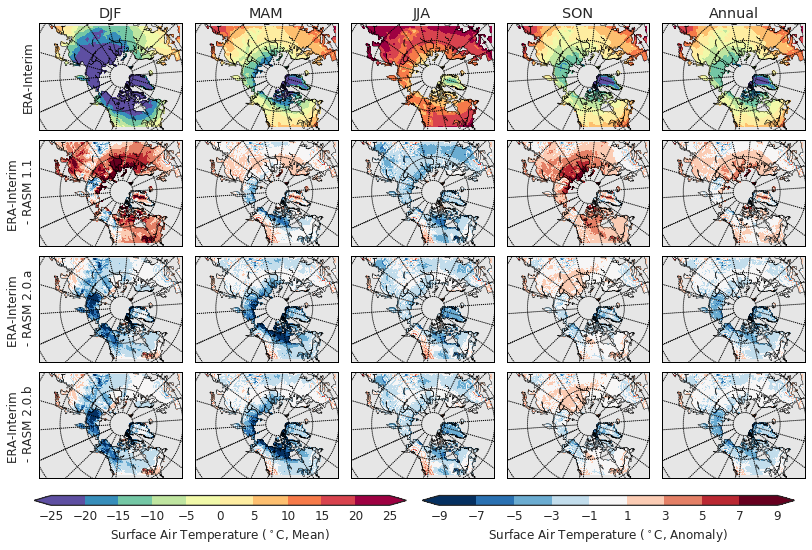

In [79]:
var = 'Tair'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = ncdata['era_interim_ts2'][var]

monthly_means['RASM 1.1'] = ncdata['RASM 1.1'][var]
monthly_means['RASM 2.0.a'] = ncdata['RASM 2.0.a'][var]
monthly_means['RASM 2.0.b'] = ncdata['RASM 2.0.b'][var]

fig, axes = plot_era_anoms(monthly_means, amin=-9, amax=9, smax=5, amap='RdBu_r',
                             varname='Surface Air Temperature', units='$^\circ C$')

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatc

RASM 1.1


/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 


RASM 2.0.a
RASM 2.0.b


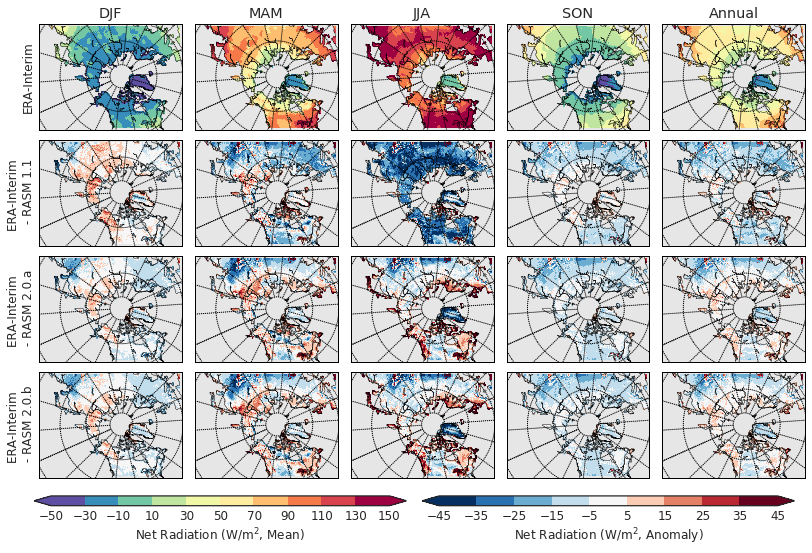

In [80]:
var = 'Radnet'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = ncdata['era_interim_ts1'][var]

monthly_means['RASM 1.1'] = ncdata['RASM 1.1'][var]
monthly_means['RASM 2.0.a'] = ncdata['RASM 2.0.a'][var]
monthly_means['RASM 2.0.b'] = ncdata['RASM 2.0.b'][var]

fig, axes = plot_era_anoms(monthly_means, vmin=-50, vmax=150, smax=20, amin=-45, amax=45, amap='RdBu_r',
                             varname='Net Radiation', units='$W/m^2$')

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatc

RASM 1.1


/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 


RASM 2.0.a
RASM 2.0.b


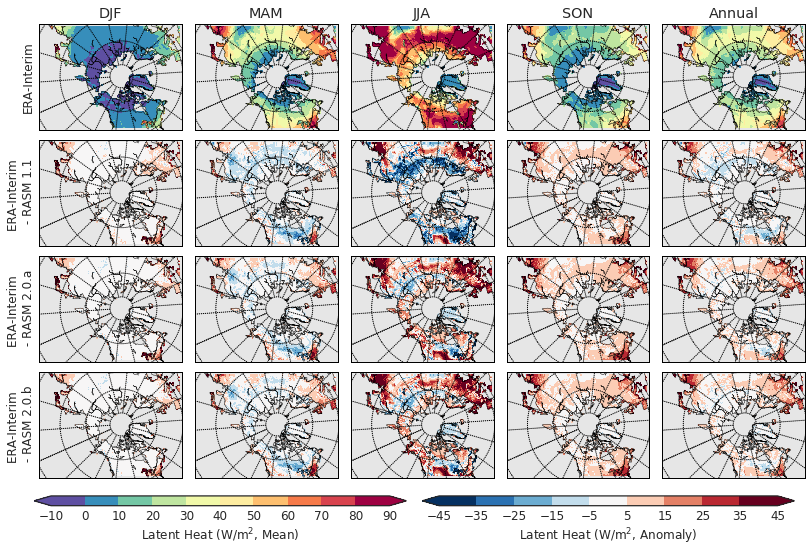

In [81]:
var = 'Latht'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = ncdata['era_interim_ts1'][var]

monthly_means['RASM 1.1'] = ncdata['RASM 1.1'][var]
monthly_means['RASM 2.0.a'] = ncdata['RASM 2.0.a'][var]
monthly_means['RASM 2.0.b'] = ncdata['RASM 2.0.b'][var]

fig, axes = plot_era_anoms(monthly_means, vmin=-10., vmax=90, smax=10, amin=-45, amax=45, amap='RdBu_r',
                             varname='Latent Heat', units='$W/m^2$')

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatc

RASM 1.1


/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 


RASM 2.0.a
RASM 2.0.b


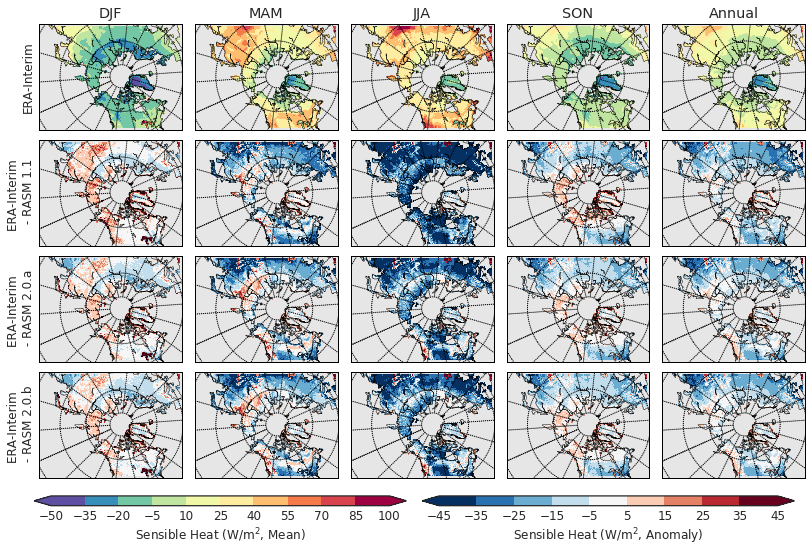

In [82]:
var = 'Senht'
monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = ncdata['era_interim_ts1'][var]

monthly_means['RASM 1.1'] = ncdata['RASM 1.1'][var]
monthly_means['RASM 2.0.a'] = ncdata['RASM 2.0.a'][var]
monthly_means['RASM 2.0.b'] = ncdata['RASM 2.0.b'][var]

fig, axes = plot_era_anoms(monthly_means, vmin=-50., vmax=100, smax=20, amin=-45, amax=45, amap='RdBu_r',
                             varname='Sensible Heat', units='$W/m^2$')

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatc

RASM 1.1


/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 


RASM 2.0.a
RASM 2.0.b


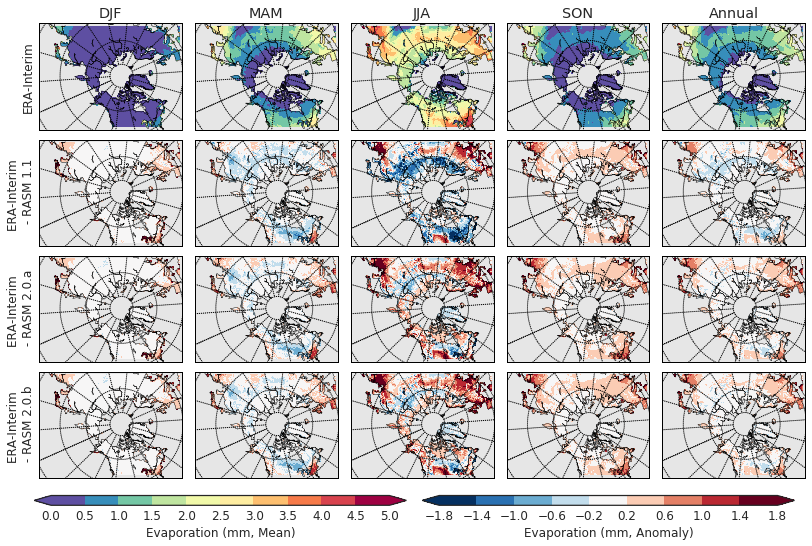

In [83]:
var = 'Evap'
var_name = 'Evaporation'
units = 'mm'

monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = ncdata['era_interim_ts3'][var]

monthly_means['RASM 1.1'] = ncdata['RASM 1.1'][var]
monthly_means['RASM 2.0.a'] = ncdata['RASM 2.0.a'][var]
monthly_means['RASM 2.0.b'] = ncdata['RASM 2.0.b'][var]

fig, axes = plot_era_anoms(monthly_means, smax=1, amin=-1.8, amax=1.8, vmin=0, vmax=5, amap='RdBu_r',
                             varname=var_name, units=units)

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatc

RASM 1.1


/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 


RASM 2.0.a
RASM 2.0.b


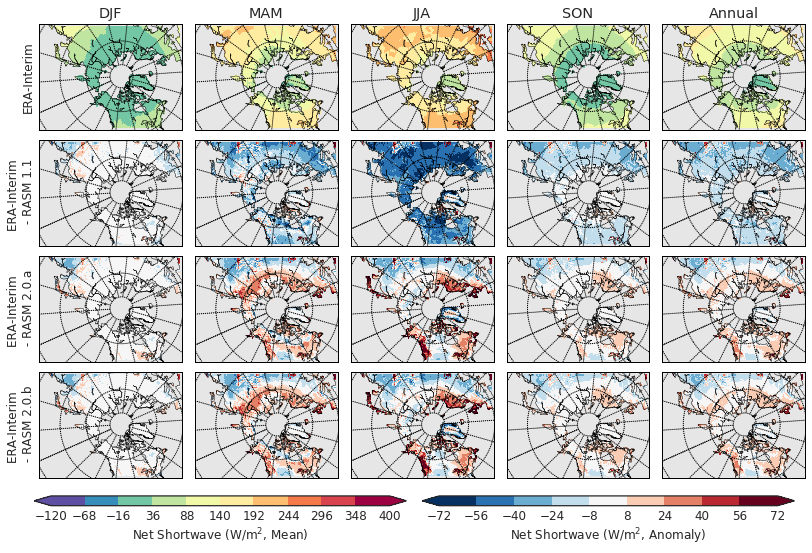

In [84]:
var = 'Swnet'
var_name = 'Net Shortwave'
units = '$W/m^2$'

monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = ncdata['era_interim_ts1'][var]

monthly_means['RASM 1.1'] = ncdata['RASM 1.1'][var]
monthly_means['RASM 2.0.a'] = ncdata['RASM 2.0.a'][var]
monthly_means['RASM 2.0.b'] = ncdata['RASM 2.0.b'][var]

fig, axes = plot_era_anoms(monthly_means, smax=20, amap='RdBu_r', vmin=-120, vmax=400, amin=-72, amax=72,
                             varname=var_name, units=units)

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatc

RASM 1.1


/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 


RASM 2.0.a
RASM 2.0.b


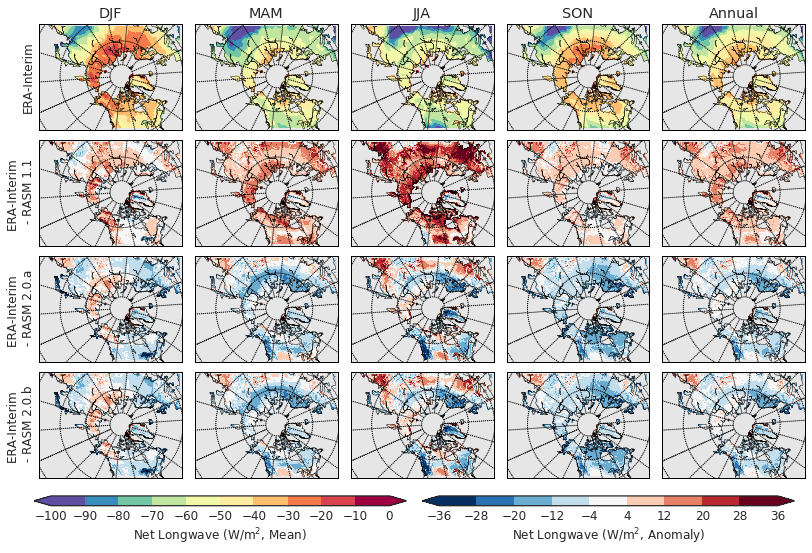

In [85]:
var = 'Lwnet'
var_name = 'Net Longwave'
units = '$W/m^2$'

monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = ncdata['era_interim_ts1'][var]

monthly_means['RASM 1.1'] = ncdata['RASM 1.1'][var]
monthly_means['RASM 2.0.a'] = ncdata['RASM 2.0.a'][var]
monthly_means['RASM 2.0.b'] = ncdata['RASM 2.0.b'][var]

fig, axes = plot_era_anoms(monthly_means, smax=10, amap='RdBu_r', vmin=-100, vmax=0, amin=-36, amax=36,
                             varname=var_name, units=units)

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatc

RASM 1.1


/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 


RASM 2.0.a
RASM 2.0.b


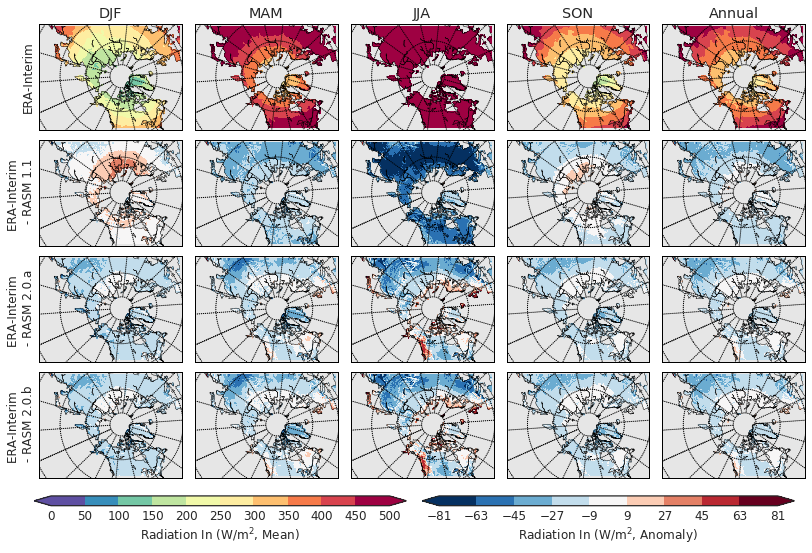

In [ ]:
var = 'Radin'
var_name = 'Radiation In'
units = '$W/m^2$'

monthly_means['ERA-Interim'] = ncdata['era_interim_ts1'][var]

monthly_means['RASM 1.1'] = ncdata['RASM 1.1'][var]
monthly_means['RASM 2.0.a'] = ncdata['RASM 2.0.a'][var]
monthly_means['RASM 2.0.b'] = ncdata['RASM 2.0.b'][var]

fig, axes = plot_era_anoms(monthly_means, smax=30, amap='RdBu_r', vmin=0, vmax=500, amin=-81, amax=81,
                             varname=var_name, units=units)

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

In [ ]:
var = 'bowen_ratio'
var_name = 'Bowen Ratio'
units = 'Qh/Ql'

monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = ncdata['era_interim_ts1'][var]

monthly_means['RASM 1.1'] = ncdata['RASM 1.1'][var]
monthly_means['RASM 2.0.a'] = ncdata['RASM 2.0.a'][var]
monthly_means['RASM 2.0.b'] = ncdata['RASM 2.0.b'][var]

fig, axes = plot_era_anoms(monthly_means, smax=10, amap='RdBu_r', vmin=0, vmax=20, amin=-20, amax=20,
                             varname=var_name, units=units)

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatc

RASM 1.1


/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="QS-SEP").mean() 
/u/home/gergel/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS").mean() 


RASM 2.0.a
RASM 2.0.b


In [ ]:
var = 'evap_frac'
var_name = 'Evaporation Fraction'
units = 'Fraction'

monthly_means = OrderedDict()

monthly_means['ERA-Interim'] = ncdata['era_interim_ts1'][var]

monthly_means['RASM 1.1'] = ncdata['RASM 1.1'][var]
monthly_means['RASM 2.0.a'] = ncdata['RASM 2.0.a'][var]
monthly_means['RASM 2.0.b'] = ncdata['RASM 2.0.b'][var]

fig, axes = plot_era_anoms(monthly_means, smax=5, amap='RdBu_r', vmin=0, vmax=1, amin=-1, amax=1,
                             varname=var_name, units=units)

plotname = '%s.png' % var
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')